**Import libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib

**Connect the notebook to my Google Drive datasets**

In [2]:
data_dir = pathlib.Path('/content/drive/MyDrive/Datasets/Meteo')
print(data_dir)
print(os.path.abspath(data_dir))

/content/drive/MyDrive/Datasets/Meteo
/content/drive/MyDrive/Datasets/Meteo


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1362


**Define constants**

In [4]:
BATCH_SIZE = 6
IMAGE_SIZE = 256

**Create the final dataset**

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1362 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['rain', 'snow']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(6, 256, 256, 3)
[0 1 1 0 1 1]


**Visualize the data**

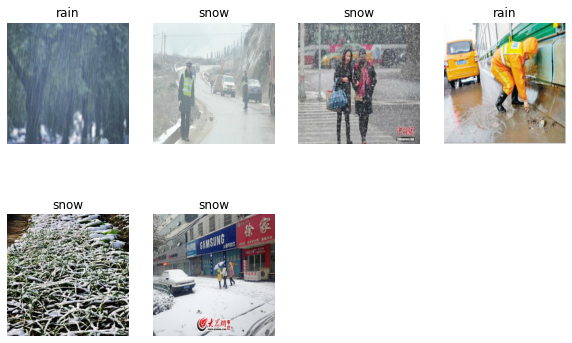

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(BATCH_SIZE):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [9]:
snow = list(data_dir.glob('snow/*'))
snow[:5]

[PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0839.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0831.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0842.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0844.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0846.jpg')]

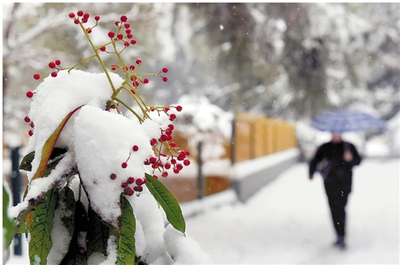

In [10]:
PIL.Image.open(str(snow[1]))

**I prepare my data before implementing it in my model architecture**

In [11]:
weather_images_dict = {
    'snow': list(data_dir.glob('snow/*')),
    'rain': list(data_dir.glob('rain/*')),
    }

In [12]:
weather_labels_dict = {
    'snow': 0,
    'rain': 1,
    }

In [13]:
weather_images_dict['snow'][:5]

[PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0839.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0831.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0842.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0844.jpg'),
 PosixPath('/content/drive/MyDrive/Datasets/Meteo/snow/0846.jpg')]

In [14]:
str(weather_images_dict['snow'][0])

'/content/drive/MyDrive/Datasets/Meteo/snow/0839.jpg'

In [15]:
import cv2

In [16]:
X, y = [], []

for weather_name, images in weather_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        try:
          resized_img = cv2.resize(img,(224,224))
        except:
          break
        X.append(resized_img)
        y.append(weather_labels_dict[weather_name])

In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**The dataset contains 1362 images, which is clearly not enough to build a powerful deep learning model.** 
<br/>
**To improve the quality of my neural network, I will use a data augmentation technique.**
<br/>
**RandomFlip, RandomRotation and RandomZoom allow to multiply the number of images by creating slightly modified versions of them.**

In [20]:
from tensorflow.keras.models import Sequential

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

The unmodified image : 

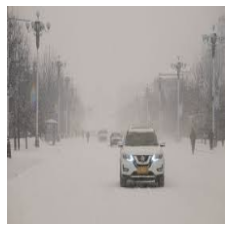

In [22]:
plt.axis('off')
plt.imshow(X[90])

One of the copies of this image, with a slight rotation :

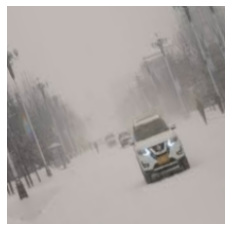

In [23]:
plt.axis('off')
plt.imshow(data_augmentation(X)[90].numpy().astype("uint8"))

**To improve my model performance, I will use a transfer learning technique.**
<br/>
**I import an already-build convolutional neural architecture called InceptionResNetV2.**

In [24]:
from tensorflow.keras.applications import InceptionResNetV2
transfer = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(180,180,3))

219070464/219055592 [==============================] - 2s 0us/step


**By implementing data_augmentation and the powerful CNN model InceptionResNetV2 into my neural network, I will boost my model performance.**
<br/>
**For the rest of the architecture, I simply choose the appropriate parameters in view of the problem I want to solve : a classification of images between two categories.**

In [ ]:
transfer.trainable = False

model = Sequential([
  data_augmentation,
  transfer,
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=20) 

Epoch 1/20
23/23 [==============================] - 119s 5s/step - loss: 4.3669 - accuracy: 0.7214
Epoch 2/20
23/23 [==============================] - 105s 5s/step - loss: 1.0496 - accuracy: 0.8487
Epoch 3/20
23/23 [==============================] - 106s 5s/step - loss: 0.5330 - accuracy: 0.8529
Epoch 4/20
23/23 [==============================] - 106s 5s/step - loss: 0.2972 - accuracy: 0.8699
Epoch 5/20
23/23 [==============================] - 105s 5s/step - loss: 0.3624 - accuracy: 0.8487
Epoch 6/20
23/23 [==============================] - 105s 5s/step - loss: 0.2439 - accuracy: 0.8925
Epoch 7/20
23/23 [==============================] - 104s 5s/step - loss: 0.1978 - accuracy: 0.9066
Epoch 8/20
23/23 [==============================] - 106s 5s/step - loss: 0.1991 - accuracy: 0.9194
Epoch 9/20
23/23 [==============================] - 105s 5s/step - loss: 0.1852 - accuracy: 0.9279
Epoch 10/20
23/23 [==============================] - 104s 5s/step - loss: 0.2025 - accuracy: 0.9194
Epoch 11/

In [ ]:
model.evaluate(X_test_scaled,y_test)

8/8 [==============================] - 39s 4s/step - loss: 0.4650 - accuracy: 0.8432


[0.46498581767082214, 0.8432203531265259]

**After training, the model shows an accuracy greather than 84%, which is satisfying given the few images I had at the beginning.**

In [ ]:
model.save('weather.h5')